# Wrangle and Analyze Data
by Victoria Perez Mola

## Table of contents

* Introduction
* Gathering data
    * WeRateDogs Twitter archive
    * Tweet image predictions
    * Twitter count & favs data
* Assessing data
    * Quality
    * Tidiness
* Cleaning data
* Storing, Analyzing, and Visualizing
* Insights & visualization
    
## Introduction

The project consists on wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. 
The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.


In [2]:
# import libraries
import requests 
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import numpy as np

## Gathering Data

The data for the analysis consists in three datasets: 

### 1. Enhanced Twitter Archive

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets. 
It contains each tweet's text, used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." 
Out of the 5000+ tweets, it contains tweets with ratings only (there are 2356).

In [269]:
# import the WeRateDogs Twitter archive
df_archive = pd.read_csv('Data/twitter-archive-enhanced.csv')

df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


### 2. Additional Data via the Twitter API

Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. 

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

Since the tweets belong to the year 2017, is possible that some don't exist anymore. I'll check the status to have an idea about what to expect. 

In [5]:
#Download Tweepy status object based on Tweet ID and store in list
valid_tweet_ids = []

# save Tweets that can't be found in a separate list
invalid_tweet_ids = []

for tweet_id in df['tweet_id']:   
    try:
        valid_tweet_ids.append(api.get_status(tweet_id))
    except Exception as e:
        invalid_tweet_ids.append(tweet_id)

Rate limit reached. Sleeping for: 730
Rate limit reached. Sleeping for: 731


In [6]:
len(valid_tweet_ids)

2331

In [7]:
len(invalid_tweet_ids)

25

Out of the 2356 tweets only 25 are not available anymore

In [16]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df.tweet_id.values
len(tweet_ids)

2356

In [17]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('Data/tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        # tweet not available
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()


1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

After retrieving the information directly from the API, we now must open the file, read the data and save it into a dataframe for an easier data handling. 
Also, we'll only keep the columns that we'll use for the analysis:
* Tweet id
* Count of retweets
* Count of favorites

In [270]:
# tweets output to a dataframe
tweet_count = []

with open('Data/tweet_json.txt','r') as file:
    for line in file:
        line_data = json.loads(line)
        tweet_count.append({'tweet_id': line_data['id'],
                        'rt_count': line_data['retweet_count'],
                        'fav_count': line_data['favorite_count']})
# assign the dataframe
df_tweet_count = pd.DataFrame(tweet_count, columns = ['tweet_id', 'rt_count', 'fav_count'])
df_tweet_count.head()

,tweet_id,rt_count,fav_count
0,892420643555336193,7746,36400
1,892177421306343426,5736,31353
2,891815181378084864,3797,23623
3,891689557279858688,7909,39689
4,891327558926688256,8533,37903


### 3. Image Predictions File

A table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

This dataset has the following columns: 

tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921

**p1** is the algorithm's #1 prediction for the image in the tweet → golden retriever

**p1_conf** is how confident the algorithm is in its #1 prediction → 95%

**p1_dog** is whether or not the #1 prediction is a breed of dog → TRUE

**p2** is the algorithm's second most likely prediction → Labrador retriever

**p2_conf** is how confident the algorithm is in its #2 prediction → 1%

**p2_dog** is whether or not the #2 prediction is a breed of dog → TRUE
etc.

This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library

In [5]:
# download the tsv file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
r = requests.get(url)

In [6]:
# write the request into a file
with open('Data/image-predictions.tsv', mode ='wb') as file:
    file.write(r.content)

In [271]:
# read the file 
df_image = pd.read_csv('Data/image-predictions.tsv', sep='\t' )

df_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1328,757400162377592832,https://pbs.twimg.com/media/CoLTbbzXYAElNM6.jpg,1,seat_belt,0.523926,False,golden_retriever,0.087800,True,Tibetan_mastiff,0.075127,True
1805,832273440279240704,https://pbs.twimg.com/ext_tw_video_thumb/832273373149413377/pu/img/qOqxM0b48fEarmq6.jpg,1,Pembroke,0.134081,True,ice_bear,0.051928,False,pug,0.044311,True
125,668248472370458624,https://pbs.twimg.com/media/CUYYcMfXAAAixe7.jpg,1,Chihuahua,0.734547,True,miniature_pinscher,0.068294,True,toy_terrier,0.046367,True
1822,834786237630337024,https://pbs.twimg.com/media/C5XBp19WYAA5a_v.jpg,1,Border_terrier,0.156276,True,Norwegian_elkhound,0.125912,True,Boston_bull,0.096624,True
718,685667379192414208,https://pbs.twimg.com/media/CYP62A6WkAAOnL4.jpg,1,sliding_door,0.344526,False,doormat,0.190027,False,washbasin,0.046326,False


## Assesing data


**Key Points**
* Only original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* Cleaning includes merging individual pieces of data according to the rules of tidy data.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



#### Twitter Archive

In [8]:
# Get a sample of the dataframe
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1066,740699697422163968,NaN,NaN,2016-06-09 00:19:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chip. He only mowed half the yard. 8/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/740699697...,8,10,Chip,None,None,None,None
55,881633300179243008,8.816070e+17,47384430.0,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
1620,684940049151070208,NaN,NaN,2016-01-07 03:30:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oreo. She's a photographer and a model...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684940049...,12,10,Oreo,None,None,None,None
2145,669926384437997569,NaN,NaN,2015-11-26 17:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've never seen a dog so genuinely happy about...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669926384...,12,10,None,None,None,None,None
1507,691675652215414786,NaN,NaN,2016-01-25 17:35:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Richie and Plip. They are the best of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691675652...,10,10,Richie,None,None,None,None


At first sight, the dataset contains dog names that are one letter long, and others are "None". 
The same happens with the stage, it's divided in four columns, when it could be just one with the stage on it. And in some cases all columns have "None" instead of empty. 

The timestamp has the +0000 at the end that is unnecesary, it should be converted to datetime type. 

The rating numerator and denominator should be one column, to facilitate the analysis. 

From a small sample of the dataframe we can see that same dogs seem to have no name or stage. 

In [9]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Additional to the type change of the timestamp, there two more data type changes: 
- The tweet_id should be changed to str, because it's a number too big for an integer. 
- The retweeted_status_timestamp should also changed to datetime, but it won't be relevant for the analysis
- in_reply_to_user_id should be a string, because is the user id, not a float, but it won't be relevant for the analysis

The columns source and in_reply_to_user_id also won't be relevant for the analysis. 

In [10]:
# Check empty values
df_archive.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
# count of unique values
df_archive.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

As said in the key points, the fact that the rating numerators are greater than the denominators does not need to be cleaned, but I'll check that there are no invalid denominators of value zero(0). 

In [12]:
sum(df_archive['rating_denominator'] == 0)

1

There's only one record with an invalid denominator, I'll check that record.

In [13]:
df_archive[df_archive['rating_denominator'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [16]:
# Change pandas setting to display the full text
pd.set_option('display.max_colwidth', None)

In [17]:
df_archive[df_archive['rating_denominator'] == 0].text

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

It's understandable that it was considered as a tweet with a rating, because it does include a rating but is not valid. This row should be discarded. 

Both numerator and denominators are set as int, check with the text to see if there are values with decimals

In [86]:
#check numerators
df_archive.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)', expand=True)[0].unique()

array(['13', '12', '14', '13.5', '17', '11', '10', '420', '666', '6',
       '15', '182', '960', '0', '9.75', '007', '84', '7', '9', '24', '8',
       '1', '5', '11.27', '3', '4', '165', '1776', '204', '50', '99',
       '80', '45', '60', '44', '143', '121', '20', '9.5', '11.26', '2',
       '144', '88'], dtype=object)

The numerators have decimals, so they should be corrected in the numerator colum, also the datatype should be changed to float to take this value

In [87]:
#check denominators
df_archive.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)', expand=True)[1].unique()

array(['10', '00', '15', '70', '7', '11', '150', '170', '20', '50', '90',
       '80', '40', '130', '110', '16', '120', '2'], dtype=object)

The numerators don't have decimals, so there's no need to correct this column

In [18]:
# Check duplicates
df_archive.duplicated().sum()

0

In [19]:
# Count dogs with no name
df_archive[df_archive['name']=='None'].shape[0]

745

In [27]:
# Check names that start with a lower case
df_archive[df_archive['name'].str.islower()].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [29]:
# Count dogs with invalid name
df_archive[df_archive['name'].str.islower()].shape[0]

109

All values in the column name that are entirely lower case are not names. 

In [33]:
# check distributions of dog stages
df_archive.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


1976 cases have no stage and 14 have two stages, all of them a combination of a doggo with some other stage

In [32]:
#check the text of dogs with more than one stage
df_count_None = df_archive.assign(count=(df_archive.loc[:, 'doggo':'puppo']!='None').sum(axis=1))

df_count_None[(df_count_None['count']>1)][['text', 'doggo','floofer','pupper','puppo']]

,text,doggo,floofer,pupper,puppo
191,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,doggo,None,None,puppo
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",doggo,floofer,None,None
460,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",doggo,None,pupper,None
531,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,doggo,None,pupper,None
565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggo,None,pupper,None
575,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,doggo,None,pupper,None
705,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,doggo,None,pupper,None
733,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",doggo,None,pupper,None
778,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,None,pupper,None
822,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,doggo,None,pupper,None


It looks like some tweets refer to two dogs, and others have more than one stage extracted from the text because of the word game. 

#### Tweet image predictions 

In [50]:
df_image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
137,668528771708952576,https://pbs.twimg.com/media/CUcXXpxWUAAUJ__.jpg,1,Labrador_retriever,0.195835,True,kuvasz,0.121607,True,English_setter,0.081464,True
1453,776819012571455488,https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
385,673345638550134785,https://pbs.twimg.com/media/CVg0SVRWEAAsBrS.jpg,1,hamster,0.761025,False,weasel,0.069362,False,Pomeranian,0.064627,True
1278,750101899009982464,https://pbs.twimg.com/media/Cmjlsh1XgAEvhq_.jpg,2,golden_retriever,0.316704,True,llama,0.174269,False,Labrador_retriever,0.147364,True
704,684926975086034944,https://pbs.twimg.com/media/CYFZXdiU0AAc_kw.jpg,1,Labrador_retriever,0.769412,True,golden_retriever,0.144893,True,lion,0.021440,False


From a sample of the dataset we can see that some of the recors may not correspond to dogs. And we don't need three predictions assigned to each image, so these values must only comprise one column with the non-dog value with the higher confidence score. 

Also, the dogs names are not consistent, some of them start with capital letters and other dont. 

In [11]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


From the info of the dataset, we can see that it has almost 300 records less than the 

In [12]:
df_image.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [13]:
df_image.duplicated().sum()

0

Other than the first observation, the dataset is quite clean, no duplicates or missing values. 

#### Twitter count & favs data

In [51]:
# Get a sample of the dataset
df_tweet_count.sample(5)

,tweet_id,rt_count,fav_count
144,863062471531167744,2300,8139
585,798628517273620480,2029,0
2182,668627278264475648,109,307
1370,700002074055016451,1344,3331
2265,667171260800061440,80,212


This dataset is very simple and pretty straight-forward. The only issue that I expect to find is an amount of records lower than the one from the previous datasets, because some tweets were not available anymore. 

In [15]:
df_tweet_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id     2331 non-null int64
rt_count     2331 non-null int64
fav_count    2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


The dataset prensents the same issue with tweet_id datatype and the amount of rows is less that the twitter archive, but still more that the image predictions dataset. 

In [16]:
# Check for missing values
df_tweet_count.isna().sum()

tweet_id     0
rt_count     0
fav_count    0
dtype: int64

In [52]:
# Check for duplicated rows
df_tweet_count.duplicated().sum()

0

In [2]:
#Check that all values are positive
(df_tweet_count.rt_count.min(),df_tweet_count.fav_count.min())

(1, 0)

In [20]:
# Check for duplicates
df_tweet_count.tweet_id.duplicated().sum()

0

### Quality Issues

As a summary of what I've encountered in the assesment of the data, the quality issues are the following:

**Twitter archive**
- Some fields have the wrong datatype and should be corrected:
    * tweet_id must be string
    * timestamp must be datetime
- Some dog names have "None" as a name instead of empty value (Nan)
- Some dog names have invalid names, should be replaced by an empty value (Nan)
- One record has an invalid denominator, equal to zero and should be discarded
- Empty dog type has "None" as a name instead of empty value (Nan)
- Some ratings are float, but the decimal is being taken as an int, they should be re extracted and adjust the data type
- Rows corresponding to retweets should be dropped

**Tweet image predictions**
- The field tweet_id must be string
- Some predictions do not correspond to dog
- The dog type starts with upper or lowercase indistinctly

**Twitter count & favs data**
- The field tweet_id must be string


### Tidiness Issues

As a summary of what I've encountered in the assesment of the data, the tidiness issues are the following:

**Twitter archive**
- The dog stages are spread in 4 columns, must be merged in one column with the different values
- Some records have more than on dog stage assigned, they should be cooncatenated
- The columns retweeted_status_timestamp,retweeted_status_user_id, in_reply_to_user_id, source and in_reply_to_user_id won't be relevant for the analysis. 
- The rating numerator and denominator should be one column, to facilitate the analysis

**Tweet image predictions**

- There are 3 predictions for each record, these values must only comprise one column with the non-dog value with the higher confidence score.

**Twitter count & favs data**


**General Issues**
- All datasets have different amount of recors, this must be unified
- Each dataset has an observation on the same record, they must be combined in one clean dataset using the key tweet_id. 

## Cleaning data

Create a copy of the datasets

In [272]:
df_archive_clean = df_archive.copy()
df_image_clean = df_image.copy()
df_tweet_count_clean = df_tweet_count.copy()

#### Issue: Wrong datatypes
##### Define
Some fields have the wrong datatype and should be corrected:
- tweet_id must be string
- timestamp must be datetime

##### Code

In [273]:
#The field tweet_id must be string in all data frames
df_archive_clean.tweet_id = df_archive_clean.tweet_id.astype(str)
df_image_clean.tweet_id = df_image_clean.tweet_id.astype(str)
df_tweet_count_clean.tweet_id = df_tweet_count_clean.tweet_id.astype(str)

#timestamp and retweeted_status_timestamp should be datetime
df_archive_clean['timestamp']= pd.to_datetime(df_archive_clean['timestamp']) 

##### Test

In [274]:
df_archive_clean.dtypes

tweet_id                                   object
in_reply_to_status_id                     float64
in_reply_to_user_id                       float64
timestamp                     datetime64[ns, UTC]
source                                     object
text                                       object
retweeted_status_id                       float64
retweeted_status_user_id                  float64
retweeted_status_timestamp                 object
expanded_urls                              object
rating_numerator                            int64
rating_denominator                          int64
name                                       object
doggo                                      object
floofer                                    object
pupper                                     object
puppo                                      object
dtype: object

#### Issue: Invalid denominator values
##### Define
Drop records with denominator equal to zero (0)

##### Code

In [275]:
df_archive_clean.drop(df_archive_clean[df_archive_clean['rating_denominator'] == 0].index, inplace=True)

##### Test

In [276]:
assert df_archive_clean[df_archive_clean['rating_denominator'] == 0].size == 0 , 'Not Clean'

#### Issue: Drop retweets records
##### Define
Some records are reweets and should be dropped (rows that have non-empty retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp)

##### Code

In [277]:
df_archive_clean.drop(df_archive_clean.index[df_archive_clean['retweeted_status_id'].notna()], inplace=True)
df_archive_clean.drop(df_archive_clean.index[df_archive_clean['retweeted_status_user_id'].notna()], inplace=True)
df_archive_clean.drop(df_archive_clean.index[df_archive_clean['retweeted_status_timestamp'].notna()], inplace=True)

##### Test

In [278]:
df_archive_clean.shape[0]

2174

In [279]:
assert df_archive_clean[df_archive_clean['retweeted_status_id'].notna()].size == 0, 'Not cleaned'

In [280]:
assert df_archive_clean[df_archive_clean['retweeted_status_user_id'].notna()].size == 0, 'Not cleaned'

In [281]:
assert df_archive_clean[df_archive_clean['retweeted_status_timestamp'].notna()].size  == 0, 'Not cleaned'

#### Issue: Invalid dog names
##### Define
Some dog names, composed only of lowercase letters, are invalid because are normal words like a,the, etc.
I'll replace it with "None" as the rest of the records with missing names, that I'll fix next.

##### Code

In [282]:
# get invalid names in a list
name_list = df_archive_clean.loc[df_archive_clean['name'].str.islower()].name.unique()

#iterate the list and replace in the dataframe
for name in name_list: 
   df_archive_clean['name'].replace(str(name),'None', inplace=True)

##### Test

In [283]:
assert df_archive_clean[df_archive_clean['name'].str.islower()].name.size == 0, 'Not cleaned'

#### Issue: Invalid missing data value
##### Define
Some records have the string value "None" as name or as a dog stage. 
All of these records should be replaced by the empty value (Nan) in columns dog name and dog type

##### Code

In [284]:
df_archive_clean.replace(to_replace='([Nn]one)', value=np.nan, regex=True, inplace=True)

##### Test

In [285]:
assert df_archive_clean[df_archive_clean['name']=='([Nn]one)'].size == 0, 'Not cleaned'

In [286]:
assert df_archive_clean[df_archive_clean['floofer']=='([Nn]one)'].size == 0, 'Not cleaned'

In [287]:
assert df_archive_clean[df_archive_clean['pupper']=='([Nn]one)'].size == 0, 'Not cleaned'

In [288]:
assert df_archive_clean[df_archive_clean['puppo']=='([Nn]one)'].size == 0, 'Not cleaned'

In [289]:
assert df_archive_clean[df_archive_clean['doggo']=='([Nn]one)'].size == 0, 'Not cleaned'

#### Issue: Combine dog states in one column 
##### Define
The dog stages are spread in 4 columns, must be merged in one column with the different values
For the records that have more than on dog stage assigned, they should be cooncatenated

##### Code

Combine dog types in one column

In [290]:
# create dog stage column
df_archive_clean['dog_stage'] = df_archive_clean.doggo.replace(np.nan, '') + df_archive_clean.floofer.replace(np.nan, '') + df_archive_clean.pupper.replace(np.nan, '') + df_archive_clean.puppo.replace(np.nan, '')

#Correct multiple dog stages values
df_archive_clean.loc[df_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_archive_clean.loc[df_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_archive_clean.loc[df_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

# set empty values '' as Nan values
df_archive_clean.replace(to_replace="" ,value=np.nan, regex=True, inplace=True)

# drop the dog stages columns, that have been replaced now
df_archive_clean.drop(['doggo','floofer', 'pupper', 'puppo'], axis=1, inplace=True);

##### Test

In [291]:
df_archive_clean.dog_stage.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [295]:
df_archive_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
1170,720775346191278080,NaN,NaN,2016-04-15 00:46:48+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Berkeley. He's in a predicament. 10/10 someone help him https://t.co/XSEXdQupej,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720775346191278080/photo/1,10,10,Berkeley,NaN
521,809920764300447744,NaN,NaN,2016-12-17 00:38:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Please only send in dogs. We only rate dogs, not seemingly heartbroken ewoks. Thank you... still 10/10 would console https://t.co/HIraYS1Bzo",NaN,NaN,NaN,https://twitter.com/dog_rates/status/809920764300447744/photo/1,10,10,NaN,NaN
1603,685943807276412928,NaN,NaN,2016-01-09 21:58:42+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685943807276412928/video/1,8,10,NaN,pupper


#### Issue: Numerators don't match the text
##### Define
Some numerators had decimals, but as it wasn't considered in the pipeline the number was extracted wrongly. 
The column rating_numerator must be a float and take the values from text

##### Code

In [296]:
#get the ratings value
ratings = df_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)', expand=True)

#assign the extracted rating numerators
df_archive_clean.rating_numerator = ratings

#adjust datatype to float
df_archive_clean.rating_numerator = df_archive_clean.rating_numerator.astype(float)

##### Test

In [297]:
df_archive_clean.rating_numerator.dtype

dtype('float64')

#### Issue: rating calculation missing
##### Define
Add one extra column to unify numerator and denominator for analysis purposes

##### Code

In [298]:
df_archive_clean['rating'] = df_archive_clean['rating_numerator']/df_archive_clean['rating_denominator']

##### Test

In [299]:
df_archive_clean['rating'].head()

0    1.3
1    1.3
2    1.2
3    1.3
4    1.2
Name: rating, dtype: float64

#### Issue: Columns not relevant for analysis
##### Define
Drop columns that won't be needed for the analysis

##### Code

In [300]:
df_archive_clean.drop(['retweeted_status_timestamp','retweeted_status_user_id',
                 'in_reply_to_user_id', 'in_reply_to_user_id','source','in_reply_to_status_id','retweeted_status_id'], 
                axis=1, inplace=True); 

##### Test

In [302]:
# Check the changes
df_archive_clean.sample(3)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating
1051,742534281772302336,2016-06-14 01:49:03+00:00,"For anyone who's wondering, this is what happens after a doggo catches it's tail... 11/10 https://t.co/G4fNhzelDv",https://vine.co/v/iLTZmtE1FTB,11.0,10,NaN,doggo,1.1
871,761599872357261312,2016-08-05 16:28:54+00:00,"This is Sephie. According to this picture, she can read. Fantastic at following directions. 11/10 such a good girl https://t.co/7HY9RvCudo",https://twitter.com/dog_rates/status/761599872357261312/photo/1,11.0,10,Sephie,NaN,1.1
1061,741303864243200000,2016-06-10 16:19:48+00:00,This is Theodore. He just saw an adult wearing crocs. Did him a frighten. Lost other ear back in nam. 12/10 hero af https://t.co/O4iw9NlLaQ,https://twitter.com/dog_rates/status/741303864243200000/photo/1,12.0,10,Theodore,NaN,1.2


#### Issue: Predictions are not dogs
##### Define
There are 3 predictions for each record, these values must only comprise one column with the non-dog value with the higher confidence score.
Also, some predictions do not correspond to dog.

##### Code

In [304]:
# Replace non dog results with confidence 0 so they don't get picked as the highest result
df_image_clean['p1_conf'] = np.where(df_image_clean['p1_dog']==False, 0, df_image_clean['p1_conf'])
df_image_clean['p2_conf'] = np.where(df_image_clean['p2_dog']==False, 0, df_image_clean['p2_conf'])
df_image_clean['p3_conf'] = np.where(df_image_clean['p3_dog']==False, 0, df_image_clean['p3_conf'])

# Add a column with the highest confidence
df_image_clean['max_conf'] = df_image_clean[['p1_conf','p2_conf','p3_conf']].max(axis=1)

#get the dog result with the max confidence for each row
df_image_clean['dog_breed'] = np.where(df_image_clean['p1_conf'] ==  df_image_clean['max_conf'] , df_image_clean['p1'], np.nan )
df_image_clean['dog_breed'] = np.where(df_image_clean['p2_conf'] ==  df_image_clean['max_conf'] , df_image_clean['p2'], df_image_clean['dog_breed'] )
df_image_clean['dog_breed'] = np.where(df_image_clean['p3_conf'] ==  df_image_clean['max_conf'] , df_image_clean['p3'], df_image_clean['dog_breed']  )

# Rows where max confidence = 0 must be NaN
df_image_clean['dog_breed'] = np.where(df_image_clean['max_conf'] == 0, np.nan, df_image_clean['dog_breed']  )

# drop the dog stages columns, that have been replaced now
df_image_clean.drop(['max_conf','p1','p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog','p3','p3_conf', 'p3_dog',], axis=1, inplace=True);

##### Test

In [305]:
df_image_clean.sample(3)

,tweet_id,jpg_url,img_num,dog_breed
667,682962037429899265,https://pbs.twimg.com/media/CXpeVzQW8AApKYb.jpg,1,Chihuahua
153,668655139528511488,https://pbs.twimg.com/media/CUeKTeYW4AEr_lx.jpg,1,beagle
1684,814153002265309185,https://pbs.twimg.com/media/C0xz04SVIAAeyDb.jpg,1,golden_retriever


#### Issue: Dog breed values start with lower or upper case indistinctly
##### Define
set all values to lower case

##### Code

In [316]:
# set all values to lower case
df_image_clean['dog_breed'] = df_image_clean['dog_breed'].str.lower()

##### Test

In [320]:
df_image_clean['dog_breed'].unique()

array(['welsh_springer_spaniel', 'redbone', 'german_shepherd',
       'rhodesian_ridgeback', 'miniature_pinscher',
       'bernese_mountain_dog', nan, 'chow', 'golden_retriever',
       'miniature_poodle', 'gordon_setter', 'walker_hound', 'pug',
       'bloodhound', 'lhasa', 'english_setter', 'italian_greyhound',
       'maltese_dog', 'newfoundland', 'malamute',
       'soft-coated_wheaten_terrier', 'chihuahua',
       'black-and-tan_coonhound', 'toy_terrier', 'blenheim_spaniel',
       'pembroke', 'irish_terrier', 'chesapeake_bay_retriever',
       'curly-coated_retriever', 'dalmatian', 'ibizan_hound',
       'border_collie', 'labrador_retriever', 'miniature_schnauzer',
       'airedale', 'rottweiler', 'west_highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'siberian_husky',
       'papillon', 'saint_bernard', 'tibetan_terrier', 'borzoi', 'beagle',
       'yorkshire_terrier', 'pomeranian', 'kuvasz',
       'flat-coated_retriever', 'norwegian_elkhound', 'boxer'

#### Issue: Some columns are not relevant for the analysis
##### Define
Drop columns that won't be used

##### Code

In [321]:
# Drop unused columns
df_image_clean.drop(['img_num'], axis=1, inplace=True);

##### Test

In [322]:
# check the change
df_image_clean.head()

,tweet_id,jpg_url,dog_breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher


#### Issue: The data is divided in three data sets
##### Define
Merge all three datasets into one using the tweet_id existing in each dataset

##### Code

In [323]:
df = pd.merge(df_archive_clean,df_image_clean, on ='tweet_id', how="inner")
df = pd.merge(df, df_tweet_count_clean, on ='tweet_id', how="inner")

##### Test

In [324]:
# check the new structure
df.sample(3)

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,jpg_url,dog_breed,rt_count,fav_count
1188,691444869282295808,2016-01-25 02:17:57+00:00,This is Bailey. She likes flowers. 12/10 https://t.co/YBENhr24FV,"https://twitter.com/dog_rates/status/691444869282295808/photo/1,https://twitter.com/dog_rates/status/691444869282295808/photo/1",12.0,10,Bailey,NaN,1.2,https://pbs.twimg.com/media/CZiBcJhWQAATXNK.jpg,bernese_mountain_dog,848,2661
1193,690959652130045952,2016-01-23 18:09:53+00:00,This golden is happy to refute the soft mouth egg test. Not a fan of sweeping generalizations. 11/10 #notallpuppers https://t.co/DgXYBDMM3E,"https://twitter.com/dog_rates/status/690959652130045952/photo/1,https://twitter.com/dog_rates/status/690959652130045952/photo/1,https://twitter.com/dog_rates/status/690959652130045952/photo/1,https://twitter.com/dog_rates/status/690959652130045952/photo/1",11.0,10,NaN,NaN,1.1,https://pbs.twimg.com/media/CZbIIM-WkAIPClg.jpg,golden_retriever,1254,3593
567,773985732834758656,2016-09-08 20:45:53+00:00,Meet Winnie. She just made awkward eye contact with the driver beside her. Poor pupper panicked. 11/10 would comfort https://t.co/RFWtDqTnAz,"https://twitter.com/dog_rates/status/773985732834758656/photo/1,https://twitter.com/dog_rates/status/773985732834758656/photo/1,https://twitter.com/dog_rates/status/773985732834758656/photo/1,https://twitter.com/dog_rates/status/773985732834758656/photo/1",11.0,10,Winnie,pupper,1.1,https://pbs.twimg.com/media/Cr2_6R8WAAAUMtc.jpg,pug,3950,10927


## Storing the clean data

In [325]:
df.to_csv('Data/twitter_archive_master.csv')

## Analyze and visualize the data

In [326]:
df = pd.read_csv('Data/twitter_archive_master.csv')

### The most common dog breed

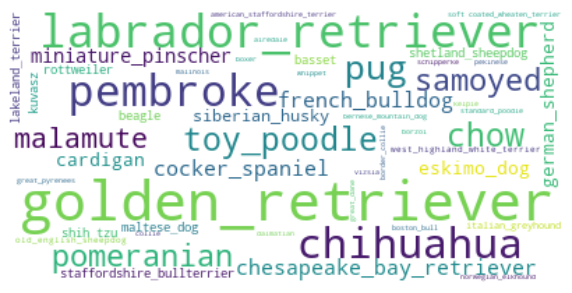

In [329]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline


# form one text variable with all dog_breeds
text = " ".join(str(text) for text in df.dog_breed)

stopwords = set(STOPWORDS)
stopwords.update(["nan"])

# Generate a word cloud image
wc = WordCloud(max_font_size=100, max_words=50, stopwords = stopwords,background_color="white").generate(text)

# store to file
wc.to_file("Data/dog_word_cloud.png")

# show
plt.figure(figsize=[10,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

It looks at first sight that the golden retriever is the dog breed that had appeared the most, followed closely by the labrador retriever.  
we can also see how many appearences the top 5 have:

In [330]:
df['dog_breed'].value_counts()[:5]/df.shape[0]

golden_retriever      0.079517
labrador_retriever    0.053347
pembroke              0.047811
chihuahua             0.045798
pug                   0.031203
Name: dog_breed, dtype: float64

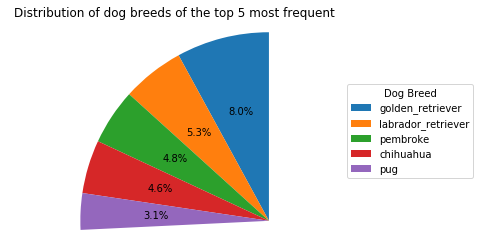

In [331]:
# Plot the 5 most frequent dog breed an it's frequency in the dataset

fig1, ax1 = plt.subplots()

ax1.pie(df['dog_breed'].value_counts()[:5]/df.shape[0], autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  
plt.title('Distribution of dog breeds of the top 5 most frequent')

ax1.legend(df['dog_breed'].value_counts()[:5].index,
          title="Dog Breed",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))


plt.show()

Although it only represents 8% of the dataset, the golder retriever is the dog breed that appears the most in the dataset.

### The better rated dogs

In [334]:
df['rating'].groupby(df['dog_stage']).mean()

dog_stage
doggo             1.187097
doggo, floofer    1.100000
doggo, pupper     1.100000
doggo, puppo      1.300000
floofer           1.200000
pupper            1.063680
puppo             1.200000
Name: rating, dtype: float64

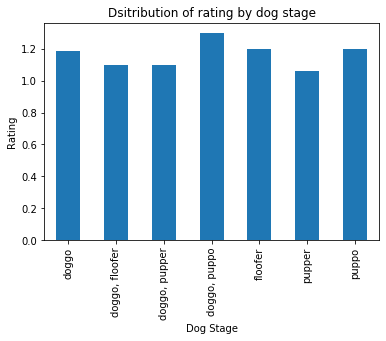

In [335]:
# plot distribution of the rating per dog stage
df['rating'].groupby(df['dog_stage']).mean().plot(kind='bar')
plt.title('Dsitribution of rating by dog stage')
plt.xlabel('Dog Stage')
plt.ylabel('Rating');

As expected, all values are over 1 (10/10), given that the numerators tend to be bigger than the denominators.

There's not much of a difference among the different stages, but it looks like the combination of doggo and puppo gets a higher rating.

In [336]:
df[df['rating'] == df['rating'].max()]

,Unnamed: 0,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,jpg_url,dog_breed,rt_count,fav_count
720,720,749981277374128128,2016-07-04 15:00:45+00:00,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10,Atticus,NaN,177.6,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,NaN,2482,5156


In [337]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg")

In [338]:
df[df['rating'] == df['rating'].max()].text

720    This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Name: text, dtype: object

### The most fav dogs

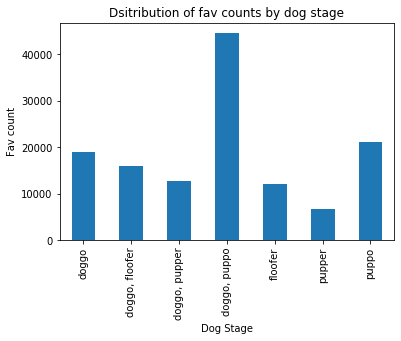

In [339]:
# plot distribution of the fav count per dog stage
df['fav_count'].groupby(df['dog_stage']).mean().plot(kind='bar')
plt.title('Dsitribution of fav counts by dog stage')
plt.xlabel('Dog Stage')
plt.ylabel('Fav count');

No doubts the puppos have the most likes! 

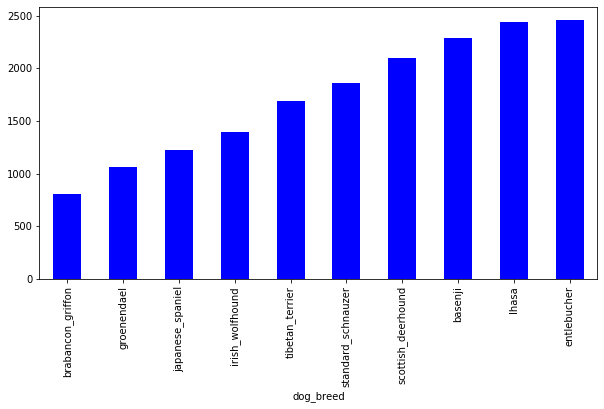

In [340]:
# plot distribution of the fav count per dog breed
df.groupby('dog_breed')['fav_count'].mean().sort_values()[:10].plot(kind = 'bar', color = 'b',figsize=(10,5));

Unlike what we saw with the ratings, the most favs went to the Lhasa dogs. 

Let's see what's the most faved dog is

In [341]:
df[df['fav_count'] == df['fav_count'].max()]

,Unnamed: 0,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,rating,jpg_url,dog_breed,rt_count,fav_count
769,769,744234799360020481,2016-06-18 18:26:18+00:00,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,https://twitter.com/dog_rates/status/744234799360020481/video/1,13.0,10,NaN,doggo,1.3,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,labrador_retriever,78283,157160


In [157]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg")

## References
- [Tweet object overview](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)
- [Tidy Data in Python article by Jean-Nicholas Hould](http://www.jeannicholashould.com/tidy-data-in-python.html)
- [Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)